# Phân Tích Dữ Liệu Bán Lẻ Quantium

Notebook này trình bày phân tích dữ liệu bán lẻ từ Quantium, tập trung vào hành vi mua hàng của khách hàng và phân tích phân khúc thị trường.


## I. Thiết Lập Môi Trường và Thư Viện


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
import re # For more complex string operations if needed

# Thiết lập hiển thị đồ thị trong notebook
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')


## II. Tải Dữ Liệu


In [2]:
# Tải dữ liệu từ các file
transaction_data_raw = pd.ExcelFile("QVI_transaction_data.xlsx")
customer_data = pd.read_csv('QVI_purchase_behaviour.csv')

# Tạo bản sao để thao tác, giữ nguyên dữ liệu gốc
transaction_data = transaction_data_raw.parse('in')


In [3]:
print("--- Thông tin ban đầu của dữ liệu giao dịch ---")
transaction_data.info()


--- Thông tin ban đầu của dữ liệu giao dịch ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [4]:
print("--- 5 dòng đầu của dữ liệu giao dịch ---")
transaction_data.head()


--- 5 dòng đầu của dữ liệu giao dịch ---


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
print("--- Thông tin ban đầu của dữ liệu khách hàng ---")
customer_data.info()


--- Thông tin ban đầu của dữ liệu khách hàng ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [6]:
print("--- 5 dòng đầu của dữ liệu khách hàng ---")
customer_data.head()


--- 5 dòng đầu của dữ liệu khách hàng ---


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


## III. Dữ Liệu Giao Dịch: Tiền Xử Lý và Phân Tích Thăm Dò


### A. Chuyển Đổi Cột Ngày (DATE)


In [7]:
print("--- Chuyển đổi cột DATE ---")
# Chuyển đổi cột DATE sang định dạng datetime
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')
print(f"Kiểu dữ liệu cột DATE sau chuyển đổi: {transaction_data['DATE'].dtype}")
transaction_data['DATE'].head()


--- Chuyển đổi cột DATE ---
Kiểu dữ liệu cột DATE sau chuyển đổi: datetime64[ns]


0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

### B. Phân Tích Cột Tên Sản Phẩm (PROD_NAME)


In [8]:
print("--- Phân tích PROD_NAME ---")
# Kiểm tra các tên sản phẩm duy nhất
print("Một số tên sản phẩm và số lượng:")
transaction_data['PROD_NAME'].value_counts().head()


--- Phân tích PROD_NAME ---
Một số tên sản phẩm và số lượng:


PROD_NAME
Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
Name: count, dtype: int64

In [9]:
# Phân tích văn bản (khám phá từ trong tên sản phẩm)
all_prod_words = transaction_data['PROD_NAME'].str.findall(r'\b\w+\b').explode().str.lower()
word_counts = all_prod_words.value_counts()
print("Các từ phổ biến nhất trong tên sản phẩm:")
word_counts.head(10)


Các từ phổ biến nhất trong tên sản phẩm:


PROD_NAME
175g        60561
chips       49770
150g        43131
kettle      41288
smiths      28860
salt        27976
cheese      27890
pringles    25102
134g        25102
doritos     24962
Name: count, dtype: int64

In [10]:
# Loại bỏ sản phẩm Salsa
salsa_mask = transaction_data['PROD_NAME'].str.lower().str.contains('salsa', na=False)
print(f"Số lượng sản phẩm salsa tìm thấy: {salsa_mask.sum()}")
transaction_data = transaction_data[~salsa_mask].copy()
print(f"Số lượng giao dịch còn lại sau khi loại bỏ salsa: {len(transaction_data)}")


Số lượng sản phẩm salsa tìm thấy: 18094
Số lượng giao dịch còn lại sau khi loại bỏ salsa: 246742


### C. Thống Kê Tóm Tắt và Quản Lý Ngoại Lệ


In [11]:
print("--- Thống kê tóm tắt ban đầu (trước khi xử lý ngoại lệ PROD_QTY) ---")
transaction_data.describe(include='all')


--- Thống kê tóm tắt ban đầu (trước khi xử lý ngoại lệ PROD_QTY) ---


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742,246742.000000,246742.000000
unique,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Kettle Mozzarella Basil & Pesto 175g,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3304,NaN,NaN
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,NaN,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,NaN,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,NaN,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,NaN,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,NaN,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,NaN,200.000000,650.000000


In [12]:
# Điều tra ngoại lệ PROD_QTY
outlier_transactions_qty_200 = transaction_data[transaction_data['PROD_QTY'] == 200]
print("Các giao dịch có PROD_QTY = 200:")
outlier_transactions_qty_200


Các giao dịch có PROD_QTY = 200:


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [13]:
if not outlier_transactions_qty_200.empty:
    # Giả sử chỉ có một khách hàng như trong tài liệu R
    outlier_customer_id = 226000 # Dựa trên tài liệu R
    customer_226000_transactions = transaction_data[transaction_data['LYLTY_CARD_NBR'] == outlier_customer_id]
    print(f"Các giao dịch của khách hàng LYLTY_CARD_NBR = {outlier_customer_id}:")
    customer_226000_transactions
    
    # Lọc bỏ khách hàng ngoại lệ
    transaction_data = transaction_data[transaction_data['LYLTY_CARD_NBR'] != outlier_customer_id].copy()
    print(f"Số lượng giao dịch còn lại sau khi loại bỏ khách hàng {outlier_customer_id}: {len(transaction_data)}")


Các giao dịch của khách hàng LYLTY_CARD_NBR = 226000:
Số lượng giao dịch còn lại sau khi loại bỏ khách hàng 226000: 246740


In [14]:
print("--- Bảng 1: Thống Kê Tóm Tắt Dữ Liệu Giao Dịch (Sau Khi Loại Bỏ Ngoại Lệ) ---")
# Đặt datetime_is_numeric=True để bao gồm cột DATE trong thống kê nếu pandas phiên bản mới hỗ trợ
try:
    summary_stats_post_outlier = transaction_data.describe(include='all', datetime_is_numeric=True)
except TypeError: # Dành cho pandas phiên bản cũ hơn không có datetime_is_numeric
    summary_stats_post_outlier = transaction_data.describe(include='all')
summary_stats_post_outlier


--- Bảng 1: Thống Kê Tóm Tắt Dữ Liệu Giao Dịch (Sau Khi Loại Bỏ Ngoại Lệ) ---


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740,246740.000000,246740.000000
unique,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Kettle Mozzarella Basil & Pesto 175g,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3304,NaN,NaN
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,NaN,1.906456,7.316113
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,NaN,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,NaN,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,NaN,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,NaN,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,NaN,5.000000,29.500000


### D. Xu Hướng Giao Dịch Theo Thời Gian


In [15]:
print("--- Xu hướng giao dịch theo thời gian ---")
# Đếm số giao dịch theo ngày
transactions_by_day_counts = transaction_data.groupby('DATE').size().reset_index(name='N')
print(f"Số ngày có giao dịch: {len(transactions_by_day_counts)}")

# Xác định và xử lý ngày bị thiếu
all_dates_df = pd.DataFrame({'DATE': pd.date_range(start="2018-07-01", end="2019-06-30", freq='D')})
transactions_by_day_full = pd.merge(all_dates_df, transactions_by_day_counts, on='DATE', how='left').fillna({'N': 0})
missing_transaction_dates = transactions_by_day_full[transactions_by_day_full['N'] == 0]
print("\nNgày không có giao dịch (ví dụ: Giáng Sinh):")
missing_transaction_dates.head()


--- Xu hướng giao dịch theo thời gian ---
Số ngày có giao dịch: 364

Ngày không có giao dịch (ví dụ: Giáng Sinh):


,DATE,N
177,2018-12-25,0.0


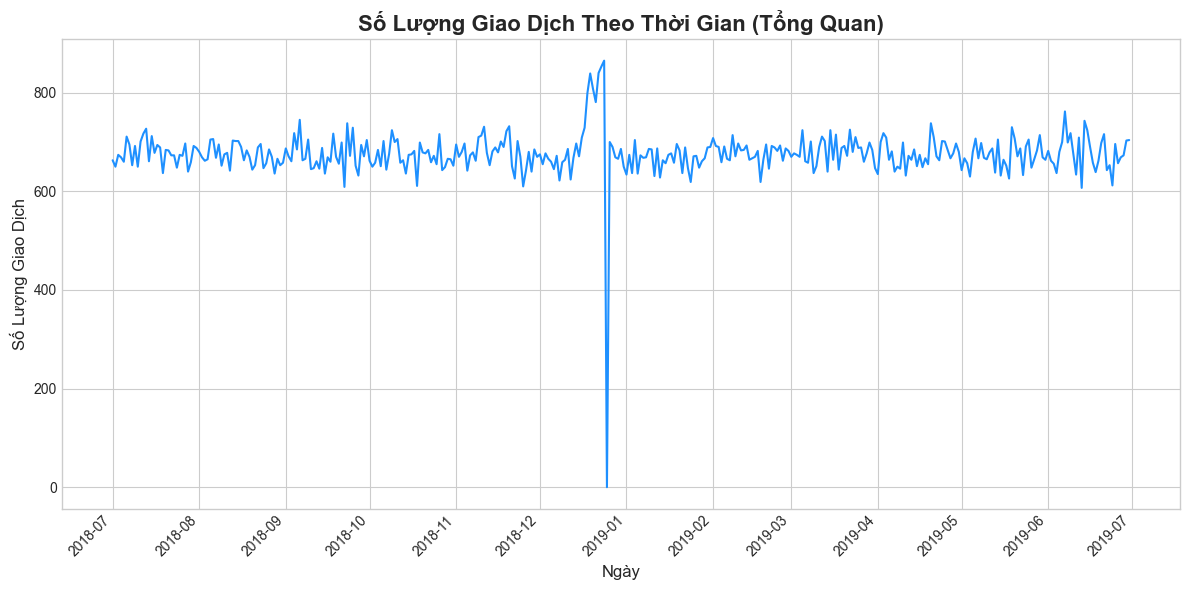

In [16]:
# Trực quan hóa khối lượng giao dịch
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='DATE', y='N', data=transactions_by_day_full, ax=ax, color='dodgerblue')
ax.set_title('Số Lượng Giao Dịch Theo Thời Gian (Tổng Quan)', fontsize=16, fontweight='bold')
ax.set_xlabel('Ngày', fontsize=12)
ax.set_ylabel('Số Lượng Giao Dịch', fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


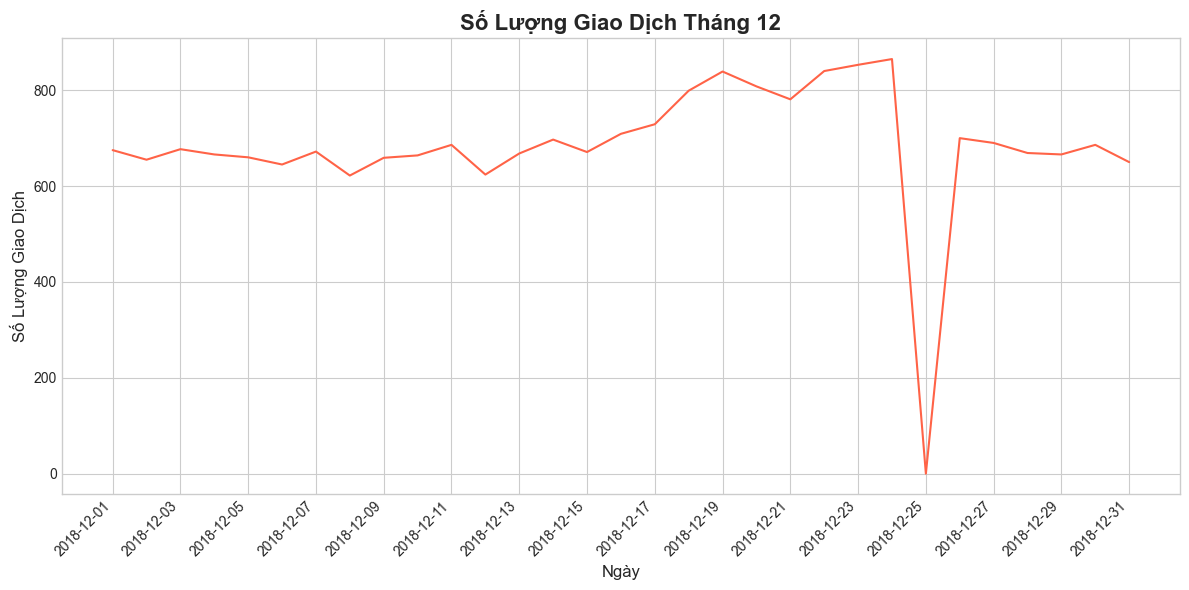

In [17]:
# Phân tích giao dịch tháng 12
december_transactions = transactions_by_day_full[transactions_by_day_full['DATE'].dt.month == 12]
fig_dec, ax_dec = plt.subplots(figsize=(12, 6))
sns.lineplot(x='DATE', y='N', data=december_transactions, ax=ax_dec, color='tomato')
ax_dec.set_title('Số Lượng Giao Dịch Tháng 12', fontsize=16, fontweight='bold')
ax_dec.set_xlabel('Ngày', fontsize=12)
ax_dec.set_ylabel('Số Lượng Giao Dịch', fontsize=12)
ax_dec.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # Hiển thị mỗi 2 ngày
ax_dec.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


## IV. Kỹ Thuật Tạo Đặc Trưng từ Dữ Liệu Giao Dịch


### A. Trích Xuất Kích Thước Gói (PACK_SIZE)


In [18]:
print("--- Kỹ thuật tạo đặc trưng ---")
# Trích xuất số cuối cùng trong tên sản phẩm, giả định đó là kích thước gói
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.findall(r'\d+').str[-1]
# Xử lý trường hợp không tìm thấy số (hiếm khi xảy ra với dữ liệu này)
transaction_data['PACK_SIZE'] = pd.to_numeric(transaction_data['PACK_SIZE'], errors='coerce').fillna(0).astype(int)

print("Một vài ví dụ về PACK_SIZE được trích xuất:")
transaction_data['PACK_SIZE'].head()


--- Kỹ thuật tạo đặc trưng ---
Một vài ví dụ về PACK_SIZE được trích xuất:


0    175
1    175
2    170
3    175
4    150
Name: PACK_SIZE, dtype: int64

In [19]:
pack_size_counts = transaction_data['PACK_SIZE'].value_counts().sort_index()
print("Phân phối PACK_SIZE:")
pack_size_counts


Phân phối PACK_SIZE:


PACK_SIZE
70      1507
90      3008
110    22387
125     1454
134    25102
135     3257
150    40203
160     2970
165    15297
170    19983
175    66390
180     1468
190     2995
200     4473
210     6272
220     1564
250     3169
270     6285
330    12540
380     6416
Name: count, dtype: int64

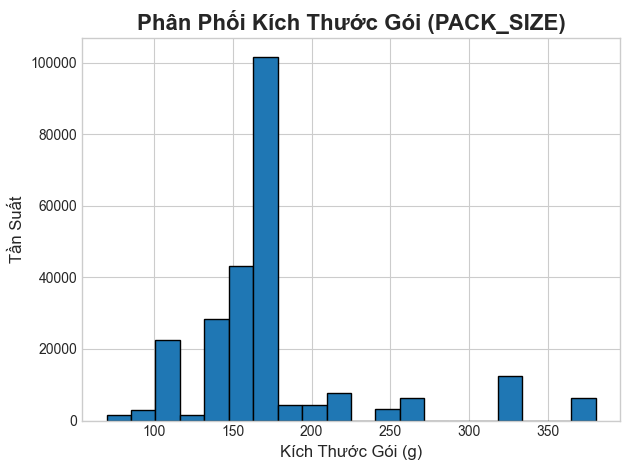

In [20]:
transaction_data['PACK_SIZE'].hist(bins=len(pack_size_counts) if len(pack_size_counts) < 50 else 50, edgecolor='black')
plt.title('Phân Phối Kích Thước Gói (PACK_SIZE)', fontsize=16, fontweight='bold')
plt.xlabel('Kích Thước Gói (g)', fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)
plt.tight_layout()


### B. Trích Xuất và Làm Sạch Thương Hiệu (BRAND)


In [21]:
# Trích xuất thương hiệu ban đầu (từ đầu tiên)
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0].str.upper()

# Chuẩn hóa tên thương hiệu
brand_cleaning_map = {
    "RED": "RRD", "SNBTS": "SUNBITES", "INFZNS": "INFUZIONS",
    "WW": "WOOLWORTHS", "SMITH": "SMITHS", "NCC": "NATURAL",
    "DORITO": "DORITOS", "GRAIN": "GRNWVES", # GRNWVES có thể là Grain Waves
    "CC'S": "CCS" # Thêm CCS từ dữ liệu R
}
transaction_data['BRAND'] = transaction_data['BRAND'].replace(brand_cleaning_map)


In [22]:
print("--- Bảng 2: Phân Phối Thương Hiệu Đã Được Làm Sạch ---")
cleaned_brand_counts = transaction_data['BRAND'].value_counts().sort_index()
cleaned_brand_counts.reset_index().rename(columns={'index':'BRAND', 'BRAND':'Count'})


--- Bảng 2: Phân Phối Thương Hiệu Đã Được Làm Sạch ---


,Count,count
0,BURGER,1564
1,CCS,4551
2,CHEETOS,2927
3,CHEEZELS,4603
4,COBS,9693
5,DORITOS,25224
6,FRENCH,1418
7,GRNWVES,7740
8,INFUZIONS,14201
9,KETTLE,41288


## V. Dữ Liệu Khách Hàng: Thăm Dò


In [23]:
print("--- Thăm dò dữ liệu khách hàng ---")
# Kiểm Tra Cấu Trúc và Tóm Tắt
print("Thông tin dữ liệu khách hàng:")
customer_data.info()


--- Thăm dò dữ liệu khách hàng ---
Thông tin dữ liệu khách hàng:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [24]:
print("Thống kê tóm tắt dữ liệu khách hàng:")
customer_data.describe(include='all')


Thống kê tóm tắt dữ liệu khách hàng:


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
count,7.263700e+04,72637,72637
unique,NaN,7,3
top,NaN,RETIREES,Mainstream
freq,NaN,14805,29245
mean,1.361859e+05,NaN,NaN
std,8.989293e+04,NaN,NaN
min,1.000000e+03,NaN,NaN
25%,6.620200e+04,NaN,NaN
50%,1.340400e+05,NaN,NaN
75%,2.033750e+05,NaN,NaN


In [25]:
# Kiểm Tra Phân Phối LIFESTAGE và PREMIUM_CUSTOMER
print("Phân phối LIFESTAGE:")
customer_data['LIFESTAGE'].value_counts()


Phân phối LIFESTAGE:


LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: count, dtype: int64

In [26]:
print("Phân phối PREMIUM_CUSTOMER:")
customer_data['PREMIUM_CUSTOMER'].value_counts()


Phân phối PREMIUM_CUSTOMER:


PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
Name: count, dtype: int64

## VI. Hợp Nhất Dữ Liệu Giao Dịch và Khách Hàng


In [27]:
print("--- Hợp nhất dữ liệu ---")
# Thực Hiện Hợp Nhất
merged_data = pd.merge(transaction_data, customer_data, on='LYLTY_CARD_NBR', how='left')
print(f"Số hàng trong dữ liệu giao dịch: {len(transaction_data)}")
print(f"Số hàng trong dữ liệu đã hợp nhất: {len(merged_data)}")


--- Hợp nhất dữ liệu ---
Số hàng trong dữ liệu giao dịch: 246740
Số hàng trong dữ liệu đã hợp nhất: 246740


In [28]:
# Xác Minh Tính Toàn Vẹn
null_lifestage_count = merged_data['LIFESTAGE'].isnull().sum()
null_premium_customer_count = merged_data['PREMIUM_CUSTOMER'].isnull().sum()
print(f"Số giá trị null trong LIFESTAGE sau khi hợp nhất: {null_lifestage_count}")
print(f"Số giá trị null trong PREMIUM_CUSTOMER sau khi hợp nhất: {null_premium_customer_count}")

if null_lifestage_count == 0 and null_premium_customer_count == 0:
    print("Hợp nhất thành công, không có giao dịch nào thiếu thông tin khách hàng.")
else:
    print("Cảnh báo: Có giao dịch thiếu thông tin khách hàng sau khi hợp nhất.")


Số giá trị null trong LIFESTAGE sau khi hợp nhất: 0
Số giá trị null trong PREMIUM_CUSTOMER sau khi hợp nhất: 0
Hợp nhất thành công, không có giao dịch nào thiếu thông tin khách hàng.


## VII. Phân Tích Phân Khúc Khách Hàng


### A. Tổng Doanh Số theo LIFESTAGE và PREMIUM_CUSTOMER


In [29]:
print("--- Phân tích phân khúc khách hàng ---")
sales_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], observed=True)['TOT_SALES'].sum().reset_index(name='SALES')
print("--- Bảng 3: Tổng Doanh Số theo LIFESTAGE và PREMIUM_CUSTOMER (Top 10) ---")
sales_by_segment.sort_values(by='SALES', ascending=False).head(10)


--- Phân tích phân khúc khách hàng ---
--- Bảng 3: Tổng Doanh Số theo LIFESTAGE và PREMIUM_CUSTOMER (Top 10) ---


,LIFESTAGE,PREMIUM_CUSTOMER,SALES
6,OLDER FAMILIES,Budget,156863.75
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20
13,RETIREES,Mainstream,145168.95
15,YOUNG FAMILIES,Budget,129717.95
9,OLDER SINGLES/COUPLES,Budget,127833.60
10,OLDER SINGLES/COUPLES,Mainstream,124648.50
11,OLDER SINGLES/COUPLES,Premium,123537.55
12,RETIREES,Budget,105916.30
7,OLDER FAMILIES,Mainstream,96413.55
14,RETIREES,Premium,91296.65


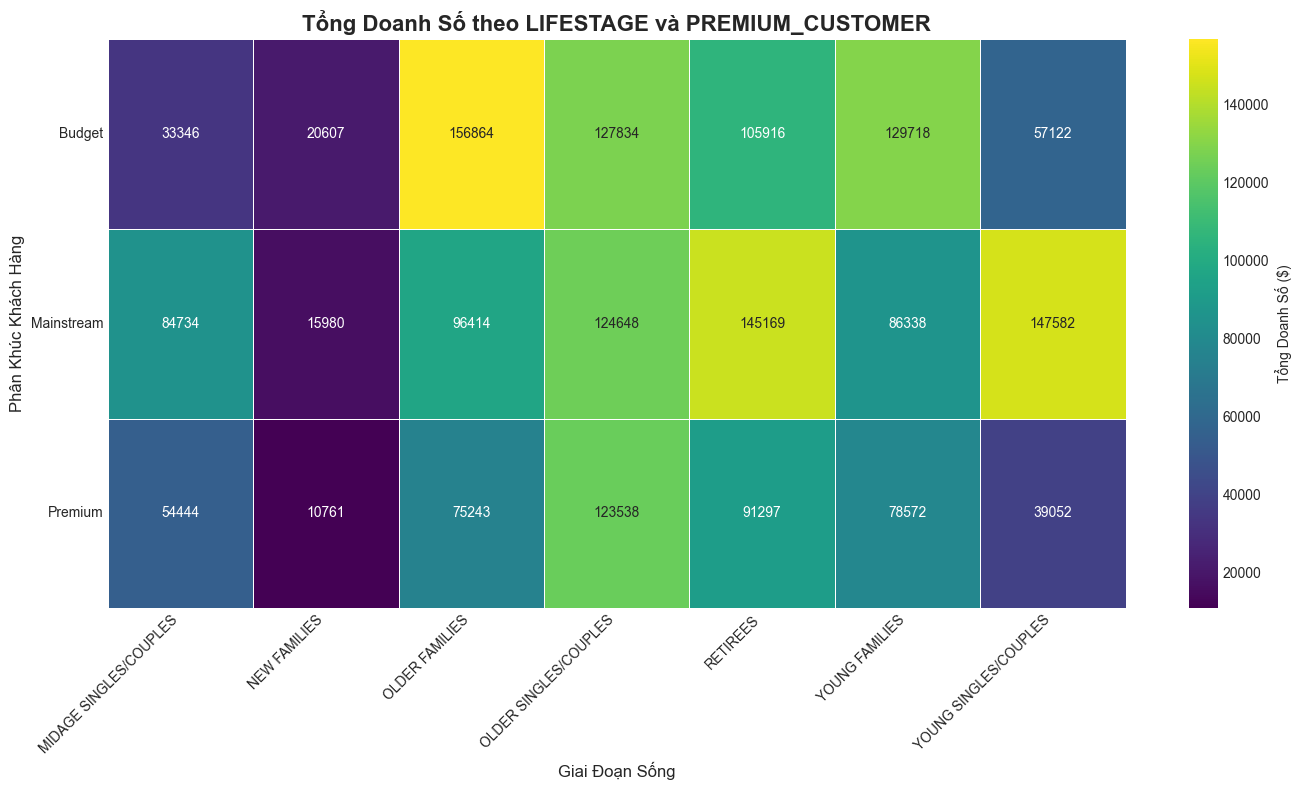

In [30]:
sales_pivot = sales_by_segment.pivot_table(index='PREMIUM_CUSTOMER', columns='LIFESTAGE', values='SALES')
plt.figure(figsize=(14, 8))
sns.heatmap(sales_pivot, annot=True, fmt=".0f", cmap="viridis", linewidths=.5,
            cbar_kws={'label': 'Tổng Doanh Số ($)'})
plt.title('Tổng Doanh Số theo LIFESTAGE và PREMIUM_CUSTOMER', fontsize=16, fontweight='bold')
plt.ylabel('Phân Khúc Khách Hàng', fontsize=12)
plt.xlabel('Giai Đoạn Sống', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


### B. Số Lượng Khách Hàng theo LIFESTAGE và PREMIUM_CUSTOMER


In [31]:
num_customers_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], observed=True)['LYLTY_CARD_NBR'].nunique().reset_index(name='CUSTOMERS')
print("--- Bảng 4: Số Lượng Khách Hàng theo LIFESTAGE và PREMIUM_CUSTOMER (Top 10) ---")
num_customers_segment.sort_values(by='CUSTOMERS', ascending=False).head(10)


--- Bảng 4: Số Lượng Khách Hàng theo LIFESTAGE và PREMIUM_CUSTOMER (Top 10) ---


,LIFESTAGE,PREMIUM_CUSTOMER,CUSTOMERS
19,YOUNG SINGLES/COUPLES,Mainstream,7917
13,RETIREES,Mainstream,6358
10,OLDER SINGLES/COUPLES,Mainstream,4858
9,OLDER SINGLES/COUPLES,Budget,4849
11,OLDER SINGLES/COUPLES,Premium,4682
6,OLDER FAMILIES,Budget,4611
12,RETIREES,Budget,4385
15,YOUNG FAMILIES,Budget,3953
14,RETIREES,Premium,3812
18,YOUNG SINGLES/COUPLES,Budget,3647


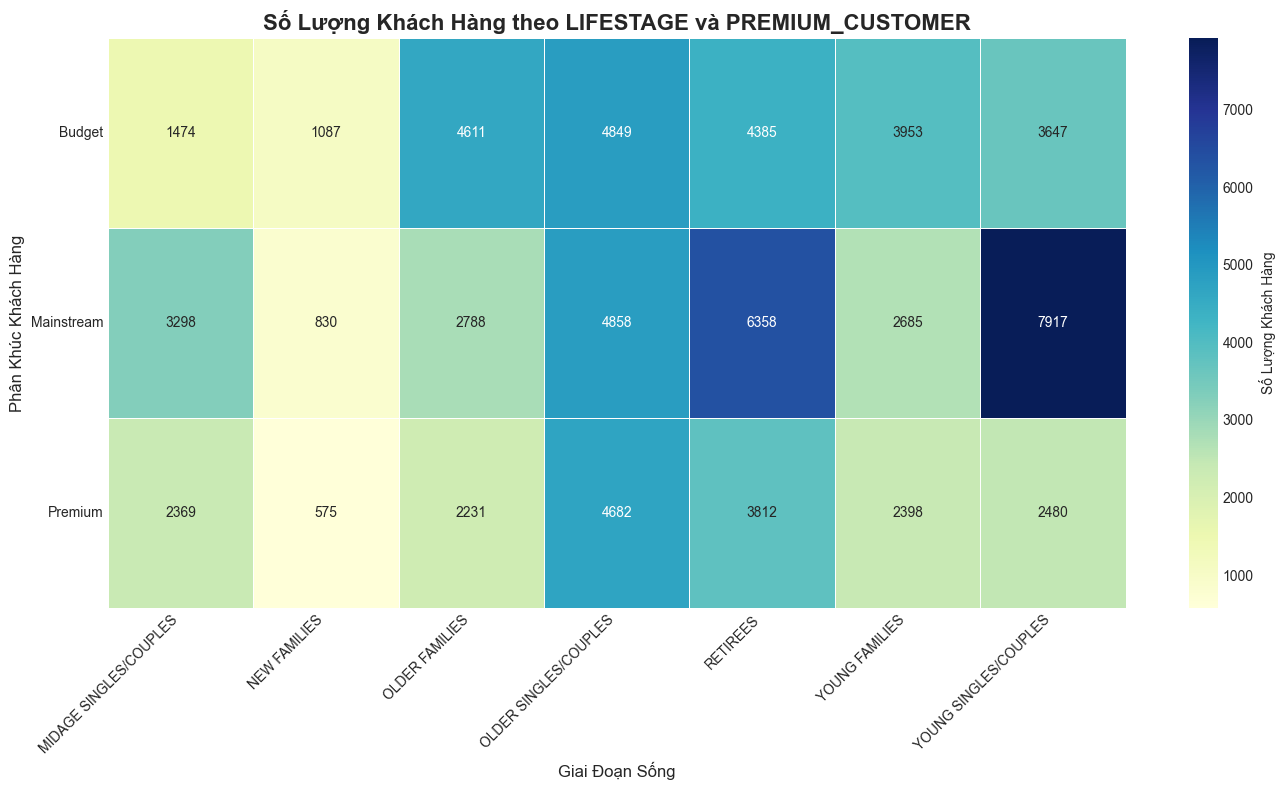

In [32]:
customers_pivot = num_customers_segment.pivot_table(index='PREMIUM_CUSTOMER', columns='LIFESTAGE', values='CUSTOMERS')
plt.figure(figsize=(14, 8))
sns.heatmap(customers_pivot, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5,
            cbar_kws={'label': 'Số Lượng Khách Hàng'})
plt.title('Số Lượng Khách Hàng theo LIFESTAGE và PREMIUM_CUSTOMER', fontsize=16, fontweight='bold')
plt.ylabel('Phân Khúc Khách Hàng', fontsize=12)
plt.xlabel('Giai Đoạn Sống', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


### C. Số Lượng Đơn Vị Trung Bình trên Mỗi Khách Hàng theo Phân Khúc


In [33]:
avg_units_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], observed=True).agg(
    total_qty=('PROD_QTY', 'sum'),
    unique_customers=('LYLTY_CARD_NBR', 'nunique')
).reset_index()
avg_units_segment['AVG_UNITS_PER_CUSTOMER'] = avg_units_segment['total_qty'] / avg_units_segment['unique_customers']
print("--- Bảng 5: Số Lượng Đơn Vị Trung Bình trên Mỗi Khách Hàng theo Phân Khúc (Top 10) ---")
avg_units_segment.sort_values(by='AVG_UNITS_PER_CUSTOMER', ascending=False).head(10)


--- Bảng 5: Số Lượng Đơn Vị Trung Bình trên Mỗi Khách Hàng theo Phân Khúc (Top 10) ---


,LIFESTAGE,PREMIUM_CUSTOMER,total_qty,unique_customers,AVG_UNITS_PER_CUSTOMER
7,OLDER FAMILIES,Mainstream,25804,2788,9.255380
6,OLDER FAMILIES,Budget,41853,4611,9.076773
8,OLDER FAMILIES,Premium,20239,2231,9.071717
15,YOUNG FAMILIES,Budget,34482,3953,8.722995
17,YOUNG FAMILIES,Premium,20901,2398,8.716013
16,YOUNG FAMILIES,Mainstream,23194,2685,8.638361
9,OLDER SINGLES/COUPLES,Budget,32883,4849,6.781398
11,OLDER SINGLES/COUPLES,Premium,31695,4682,6.769543
10,OLDER SINGLES/COUPLES,Mainstream,32607,4858,6.712021
1,MIDAGE SINGLES/COUPLES,Mainstream,21213,3298,6.432080


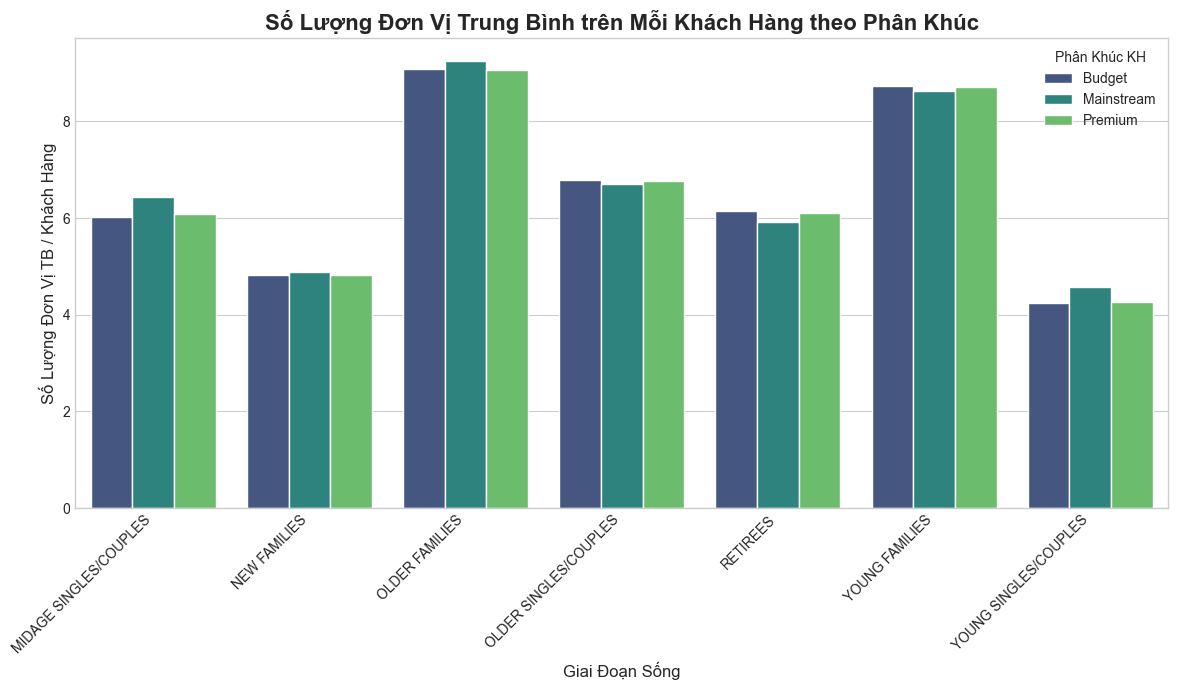

In [34]:
plt.figure(figsize=(12, 7))
sns.barplot(x='LIFESTAGE', y='AVG_UNITS_PER_CUSTOMER', hue='PREMIUM_CUSTOMER', data=avg_units_segment, palette='viridis', dodge=True)
plt.title('Số Lượng Đơn Vị Trung Bình trên Mỗi Khách Hàng theo Phân Khúc', fontsize=16, fontweight='bold')
plt.xlabel('Giai Đoạn Sống', fontsize=12)
plt.ylabel('Số Lượng Đơn Vị TB / Khách Hàng', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Phân Khúc KH')
plt.tight_layout()


### D. Giá Trung Bình trên Mỗi Đơn Vị theo Phân Khúc


In [35]:
avg_price_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], observed=True).agg(
    total_sales_val=('TOT_SALES', 'sum'),
    total_qty_val=('PROD_QTY', 'sum')
).reset_index()
avg_price_segment['AVG_PRICE_PER_UNIT'] = avg_price_segment['total_sales_val'] / avg_price_segment['total_qty_val']
print("--- Bảng 6: Giá Trung Bình trên Mỗi Đơn Vị theo Phân Khúc (Top 10) ---")
avg_price_segment.sort_values(by='AVG_PRICE_PER_UNIT', ascending=False).head(10)


--- Bảng 6: Giá Trung Bình trên Mỗi Đơn Vị theo Phân Khúc (Top 10) ---


,LIFESTAGE,PREMIUM_CUSTOMER,total_sales_val,total_qty_val,AVG_PRICE_PER_UNIT
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20,36225,4.074043
1,MIDAGE SINGLES/COUPLES,Mainstream,84734.25,21213,3.994449
4,NEW FAMILIES,Mainstream,15979.70,4060,3.935887
12,RETIREES,Budget,105916.30,26932,3.932731
3,NEW FAMILIES,Budget,20607.45,5241,3.931969
14,RETIREES,Premium,91296.65,23266,3.924037
11,OLDER SINGLES/COUPLES,Premium,123537.55,31695,3.897698
9,OLDER SINGLES/COUPLES,Budget,127833.60,32883,3.887529
5,NEW FAMILIES,Premium,10760.80,2769,3.886168
13,RETIREES,Mainstream,145168.95,37677,3.852986


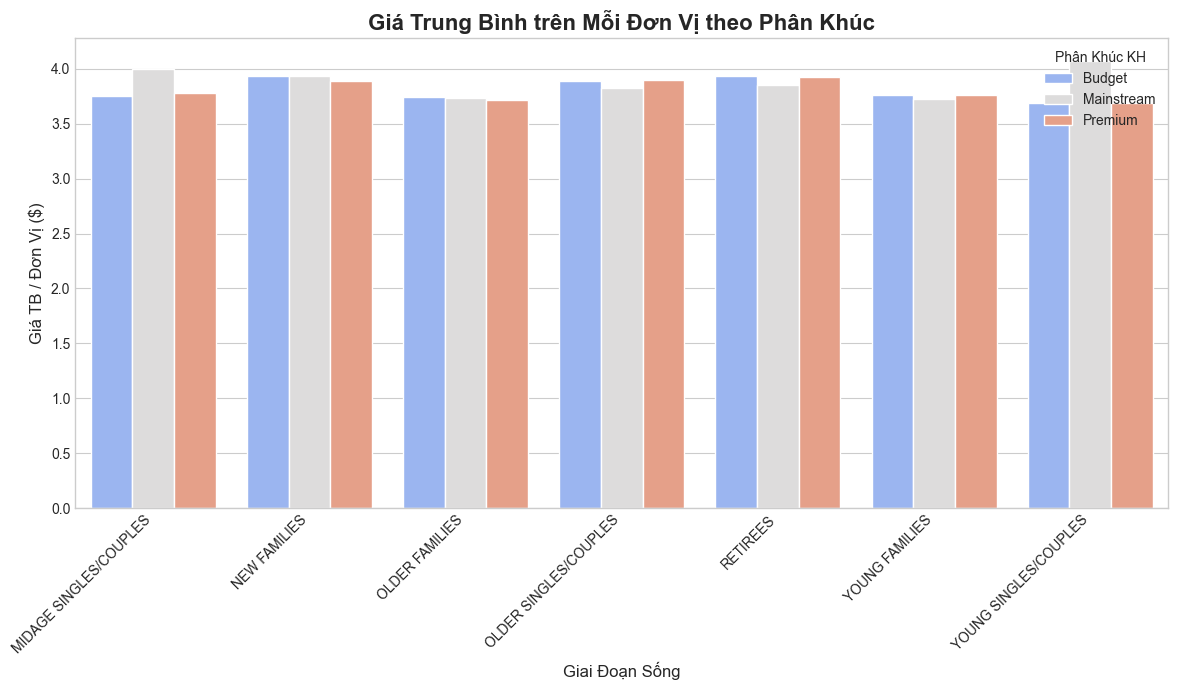

In [36]:
plt.figure(figsize=(12, 7))
sns.barplot(x='LIFESTAGE', y='AVG_PRICE_PER_UNIT', hue='PREMIUM_CUSTOMER', data=avg_price_segment, palette='coolwarm', dodge=True)
plt.title('Giá Trung Bình trên Mỗi Đơn Vị theo Phân Khúc', fontsize=16, fontweight='bold')
plt.xlabel('Giai Đoạn Sống', fontsize=12)
plt.ylabel('Giá TB / Đơn Vị ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Phân Khúc KH')
plt.tight_layout()


### E. Kiểm Định Ý Nghĩa Thống Kê (T-test)


In [37]:
# Tính giá trên mỗi đơn vị cho từng giao dịch
merged_data['PRICE_PER_UNIT'] = merged_data['TOT_SALES'] / merged_data['PROD_QTY']

# Định nghĩa các nhóm cho t-test
group_mainstream = merged_data[
    (merged_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (merged_data['PREMIUM_CUSTOMER'] == "Mainstream")
]['PRICE_PER_UNIT'].dropna()

group_other = merged_data[
    (merged_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (merged_data['PREMIUM_CUSTOMER'].isin(["Budget", "Premium"])) # Bao gồm Budget và Premium
]['PRICE_PER_UNIT'].dropna()


In [ ]:
if not group_mainstream.empty and not group_other.empty:
    t_stat, p_value = stats.ttest_ind(group_mainstream, group_other,
                                      equal_var=False, # Welch's t-test
                                      alternative='greater') # Kiểm tra xem mainstream có lớn hơn không
    print("--- Bảng 7: Kết Quả T-test cho Giá Mỗi Đơn Vị ---")
    print(f"So sánh: Mainstream (Young/Midage Singles/Couples) vs. Budget/Premium (Young/Midage Singles/Couples)")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}") # Định dạng p-value để dễ đọc
    print(f"Giá TB (Mainstream): {group_mainstream.mean():.4f}")
    print(f"Giá TB (Budget/Premium): {group_other.mean():.4f}")
    if p_value < 0.05:
        print("Kết luận: Có bằng chứng thống kê cho thấy nhóm Mainstream trả giá mỗi đơn vị cao hơn đáng kể.")
    else:
        print("Kết luận: Không có đủ bằng chứng thống kê cho thấy nhóm Mainstream trả giá mỗi đơn vị cao hơn đáng kể.")
else:
    print("Không đủ dữ liệu để thực hiện T-test cho các nhóm đã chọn.")


## VIII. Phân Tích Sâu: Phân Khúc 'Mainstream, Young Singles/Couples'


In [39]:
print("--- Phân tích sâu: Mainstream, Young Singles/Couples ---")
target_lifestage = "YOUNG SINGLES/COUPLES"
target_premium = "Mainstream"

# Lọc phân khúc mục tiêu
segment1 = merged_data[
    (merged_data['LIFESTAGE'] == target_lifestage) &
    (merged_data['PREMIUM_CUSTOMER'] == target_premium)
].copy()

# Các phân khúc khác (tất cả khách hàng không thuộc phân khúc mục tiêu)
other_segments = merged_data[
    ~((merged_data['LIFESTAGE'] == target_lifestage) &
      (merged_data['PREMIUM_CUSTOMER'] == target_premium))
].copy()


--- Phân tích sâu: Mainstream, Young Singles/Couples ---


### A. Phân Tích Mức Độ Ưa Thích Thương Hiệu


In [40]:
if not segment1.empty and not other_segments.empty:
    # Tính tổng số lượng sản phẩm cho mỗi nhóm
    quantity_segment1_total = segment1['PROD_QTY'].sum()
    quantity_other_total = other_segments['PROD_QTY'].sum()
    
    # Tính tỷ lệ mỗi thương hiệu trong tổng số lượng
    quantity_segment1_by_brand = segment1.groupby('BRAND', observed=True)['PROD_QTY'].sum() / quantity_segment1_total
    quantity_other_by_brand = other_segments.groupby('BRAND', observed=True)['PROD_QTY'].sum() / quantity_other_total
    
    # Tính mức độ ưa thích thương hiệu
    brand_affinity = pd.merge(
        quantity_segment1_by_brand.rename('targetSegment'),
        quantity_other_by_brand.rename('other'),
        on='BRAND', how='outer'
    ).fillna(0)
    brand_affinity['affinityToBrand'] = brand_affinity['targetSegment'] / brand_affinity['other']
    brand_affinity.replace([float('inf'), -float('inf')], pd.NA, inplace=True) # Xử lý chia cho 0
    brand_affinity.dropna(subset=['affinityToBrand'], inplace=True) # Loại bỏ NA do chia cho 0
    
    print("--- Bảng 8: Mức Độ Ưa Thích Thương Hiệu của Phân Khúc 'Mainstream, Young Singles/Couples' (Top 10) ---")
    brand_affinity.sort_values(by='affinityToBrand', ascending=False).head(10)


--- Bảng 8: Mức Độ Ưa Thích Thương Hiệu của Phân Khúc 'Mainstream, Young Singles/Couples' (Top 10) ---


### B. Phân Tích Sở Thích Kích Thước Gói


In [41]:
if not segment1.empty and not other_segments.empty:
    # Tính tỷ lệ mỗi kích thước gói trong tổng số lượng
    quantity_segment1_by_pack = segment1.groupby('PACK_SIZE')['PROD_QTY'].sum() / quantity_segment1_total
    quantity_other_by_pack = other_segments.groupby('PACK_SIZE')['PROD_QTY'].sum() / quantity_other_total
    
    # Tính mức độ ưa thích kích thước gói
    pack_affinity = pd.merge(
        quantity_segment1_by_pack.rename('targetSegment'),
        quantity_other_by_pack.rename('other'),
        on='PACK_SIZE', how='outer'
    ).fillna(0)
    pack_affinity['affinityToPack'] = pack_affinity['targetSegment'] / pack_affinity['other']
    pack_affinity.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
    pack_affinity.dropna(subset=['affinityToPack'], inplace=True)
    
    print("--- Bảng 9: Sở Thích Kích Thước Gói của Phân Khúc 'Mainstream, Young Singles/Couples' (Top 10) ---")
    pack_affinity.sort_values(by='affinityToPack', ascending=False).head(10)


--- Bảng 9: Sở Thích Kích Thước Gói của Phân Khúc 'Mainstream, Young Singles/Couples' (Top 10) ---


In [42]:
if not segment1.empty and not other_segments.empty:
    # Điều tra các thương hiệu cho kích thước gói có mức độ ưa thích cao
    high_affinity_pack_size = 270 # Dựa trên kết quả từ tài liệu R
    if high_affinity_pack_size in pack_affinity.index: # Kiểm tra xem kích thước gói có tồn tại trong kết quả không
        brands_for_pack_size_270 = merged_data[merged_data['PACK_SIZE'] == high_affinity_pack_size]['BRAND'].unique()
        print(f"Các sản phẩm có kích thước gói {high_affinity_pack_size}g: {', '.join(brands_for_pack_size_270)}")
    else:
        # Phương án dự phòng nếu 270g không phải là kích thước hàng đầu, chọn kích thước hàng đầu từ tính toán
        if not pack_affinity.empty:
            top_pack_size_from_py = pack_affinity.sort_values(by='affinityToPack', ascending=False).index[0]
            brands_for_top_pack_size = merged_data[merged_data['PACK_SIZE'] == top_pack_size_from_py]['BRAND'].unique()
            print(f"Các sản phẩm có kích thước gói ưa thích nhất ({top_pack_size_from_py}g): {', '.join(brands_for_top_pack_size)}")
else:
    print("Không đủ dữ liệu trong segment1 hoặc other_segments để thực hiện phân tích sâu.")


Các sản phẩm có kích thước gói 270g: TWISTIES


## IX. Kết Luận và Tóm Tắt Phân Tích

Từ phân tích trên, chúng ta có thể rút ra một số kết luận chính:

1. **Xu hướng mua sắm theo thời gian**: Có sự biến động rõ rệt trong khối lượng giao dịch theo thời gian, với các đỉnh điểm vào các dịp lễ và sự sụt giảm vào các ngày đặc biệt như Giáng sinh.

2. **Phân khúc khách hàng chính**: Phân khúc "Mainstream, Young Singles/Couples" và "Budget, Older Families" có doanh số cao nhất.

3. **Hành vi mua sắm theo phân khúc**:
   - Khách hàng "Mainstream, Young Singles/Couples" có xu hướng mua nhiều sản phẩm hơn so với các phân khúc khác.
   - Phân khúc này cũng có sở thích rõ ràng đối với một số thương hiệu cụ thể và kích thước gói 270g.

4. **Giá trị đơn vị**: Có bằng chứng thống kê cho thấy khách hàng "Mainstream" trong nhóm "Young/Midage Singles/Couples" trả giá cao hơn cho mỗi đơn vị sản phẩm so với các nhóm "Budget" và "Premium" trong cùng phân khúc tuổi.

5. **Cơ hội tiếp thị**: Dựa trên phân tích ưa thích thương hiệu và kích thước gói, có thể xác định các cơ hội tiếp thị cụ thể cho phân khúc "Mainstream, Young Singles/Couples".

Những phát hiện này cung cấp thông tin quý giá cho việc phát triển chiến lược tiếp thị và sản phẩm nhằm vào các phân khúc khách hàng cụ thể, đặc biệt là phân khúc "Mainstream, Young Singles/Couples".